In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Load cleaned + scaled dataset
df = pd.read_csv("C:/Users/BALA/OneDrive - University of Hertfordshire/Desktop/mutual-fund-recommender/data/processed/preprocessed_mutual_funds.csv")
df['Date'] = pd.to_datetime(df['Date'])

print("Data loaded:", df.shape)


Data loaded: (29033646, 8)


## Select Top 5 Most Frequent Scheme_Codes

In [41]:
top_5_schemes = df['Scheme_Code'].value_counts().head(5).index.tolist()
print(" Top 5 Schemes:", top_5_schemes)


 Top 5 Schemes: [101206, 103140, 102012, 102008, 102009]


## ARIMA Forecasting Loop

In [42]:
import warnings
warnings.filterwarnings("ignore") 

results = []
all_forecasts = {}

for code in top_5_schemes:
    print(f"\n Processing Scheme_Code: {code}")
    scheme_df = df[df['Scheme_Code'] == code].sort_values("Date")
    scheme_df.set_index("Date", inplace=True)

    ts = scheme_df['NAV_scaled']

    # Train-test split (80/20)
    split = int(len(ts) * 0.8)
    train, test = ts[:split], ts[split:]

    try:
        model = ARIMA(train, order=(2, 1, 2))  # Try (2,1,2) first
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))

        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)

        results.append({
            'Scheme_Code': code,
            'RMSE': rmse,
            'MAE': mae,
            'Train_Size': len(train),
            'Test_Size': len(test)
        })

        # Save for later plotting
        all_forecasts[code] = {
            'train': train,
            'test': test,
            'forecast': forecast
        }

    except Exception as e:
        print(f" Error with {code}: {e}")



 Processing Scheme_Code: 101206

 Processing Scheme_Code: 103140

 Processing Scheme_Code: 102012
 Error with 102012: Schur decomposition solver error.

 Processing Scheme_Code: 102008

 Processing Scheme_Code: 102009


## Display Leaderboard

In [43]:
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n ARIMA Leaderboard (sorted by RMSE):")
display(results_df)



 ARIMA Leaderboard (sorted by RMSE):


,Scheme_Code,RMSE,MAE,Train_Size,Test_Size
1,103140,0.055611,0.042457,4852,1213
0,101206,0.074520,0.064020,4852,1213
3,102009,0.124912,0.110629,4766,1192
2,102008,0.466392,0.391786,4766,1192


## Plot Forecast for Best Scheme

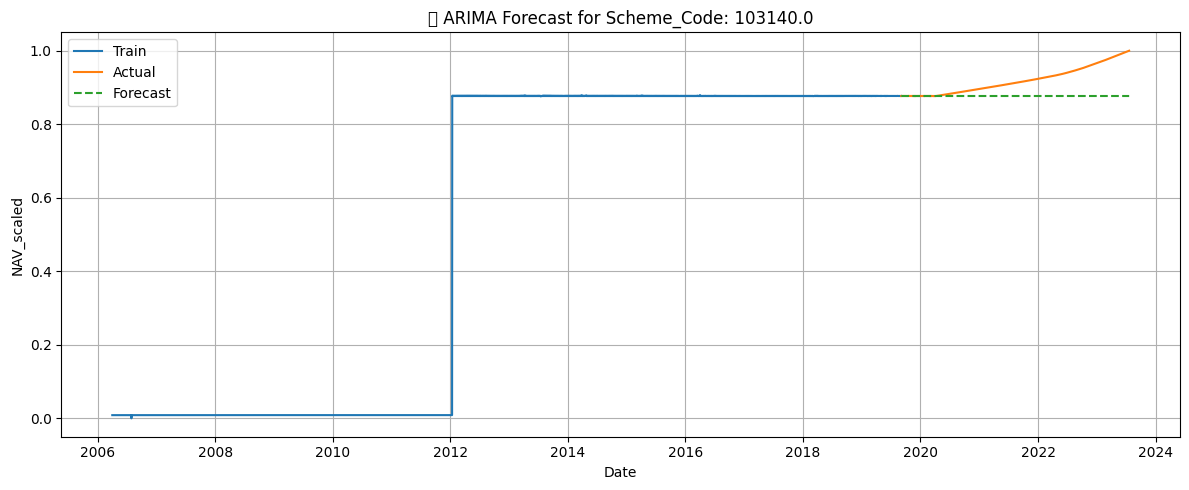

In [44]:
best_scheme = results_df.iloc[0]['Scheme_Code']
data = all_forecasts[best_scheme]

plt.figure(figsize=(12, 5))
plt.plot(data['train'], label='Train')
plt.plot(data['test'], label='Actual')
plt.plot(data['test'].index, data['forecast'], label='Forecast', linestyle='--')
plt.title(f"📈 ARIMA Forecast for Scheme_Code: {best_scheme}")
plt.xlabel("Date")
plt.ylabel("NAV_scaled")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [46]:
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [47]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model



 Training LSTM for Scheme: 101206
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


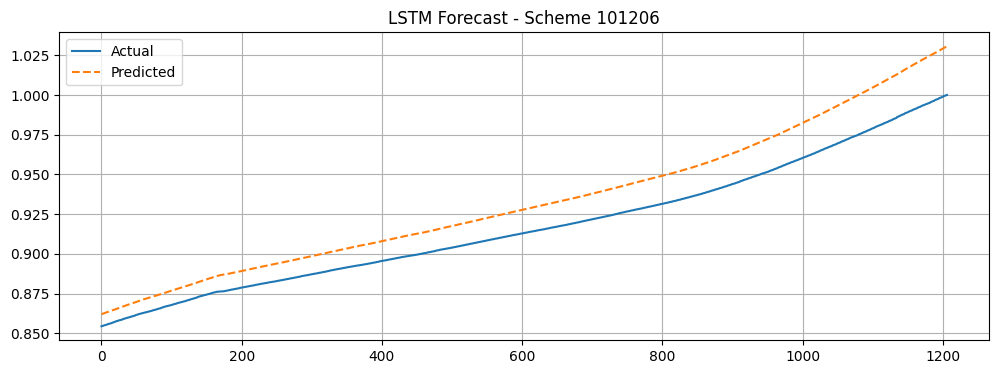


 Training LSTM for Scheme: 103140
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

 Training LSTM for Scheme: 102012
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

 Training LSTM for Scheme: 102008
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

 Training LSTM for Scheme: 102009
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [48]:
lstm_forecasts = {}  # to store predictions per scheme
results_lstm = []
window_size = 30
epochs = 10  # can increase for better performance

for code in top_5_schemes:
    print(f"\n Training LSTM for Scheme: {code}")
    scheme_df = df[df['Scheme_Code'] == code].sort_values('Date')
    ts = scheme_df['NAV_scaled'].values

    # Create sequences
    X, y = create_sequences(ts, window_size)

    # Train-test split (80/20)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    try:
        # Build + train model
        model = build_lstm_model((window_size, 1))
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

        # Predict
        y_pred = model.predict(X_test)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        results_lstm.append({
            'Scheme_Code': code,
            'RMSE': rmse,
            'MAE': mae
        })

        # Optional: Plot one forecast
        if code == top_5_schemes[0]:
            plt.figure(figsize=(12, 4))
            plt.plot(y_test, label='Actual')
            plt.plot(y_pred, label='Predicted', linestyle='--')
            plt.title(f'LSTM Forecast - Scheme {code}')
            plt.legend()
            plt.grid(True)
            plt.show()

    except Exception as e:
        print(f" Error with LSTM for {code}: {e}")


In [49]:
results_lstm_df = pd.DataFrame(results_lstm).sort_values(by='RMSE')
print("\n LSTM Leaderboard:")
display(results_lstm_df)



 LSTM Leaderboard:


,Scheme_Code,RMSE,MAE
1,103140,0.010989,0.007837
3,102008,0.011130,0.007961
0,101206,0.017000,0.015993
2,102012,0.017628,0.015314
4,102009,0.030250,0.025921


# Prophet Model

In [50]:
!pip install prophet --quiet

In [51]:
from prophet import Prophet


In [52]:
def run_prophet_forecast(scheme_df, forecast_days=30):
    # Prepare data
    prophet_df = scheme_df[['Date', 'NAV_scaled']].rename(columns={
        'Date': 'ds',
        'NAV_scaled': 'y'
    })

    # Train-test split (e.g. 80/20 based on index)
    split_idx = int(len(prophet_df) * 0.8)
    train_df = prophet_df.iloc[:split_idx]
    test_df = prophet_df.iloc[split_idx:]

    # Build and fit model
    model = Prophet()
    model.fit(train_df)

    # Predict into test range
    future = model.make_future_dataframe(periods=len(test_df), freq='D')
    forecast = model.predict(future)

    # Align forecast with actual
    forecast_trimmed = forecast.iloc[-len(test_df):]['yhat'].values
    y_true = test_df['y'].values

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, forecast_trimmed))
    mae = mean_absolute_error(y_true, forecast_trimmed)

    return y_true, forecast_trimmed, rmse, mae, model, forecast



 Running Prophet for Scheme: 101206


22:12:34 - cmdstanpy - INFO - Chain [1] start processing
22:12:37 - cmdstanpy - INFO - Chain [1] done processing


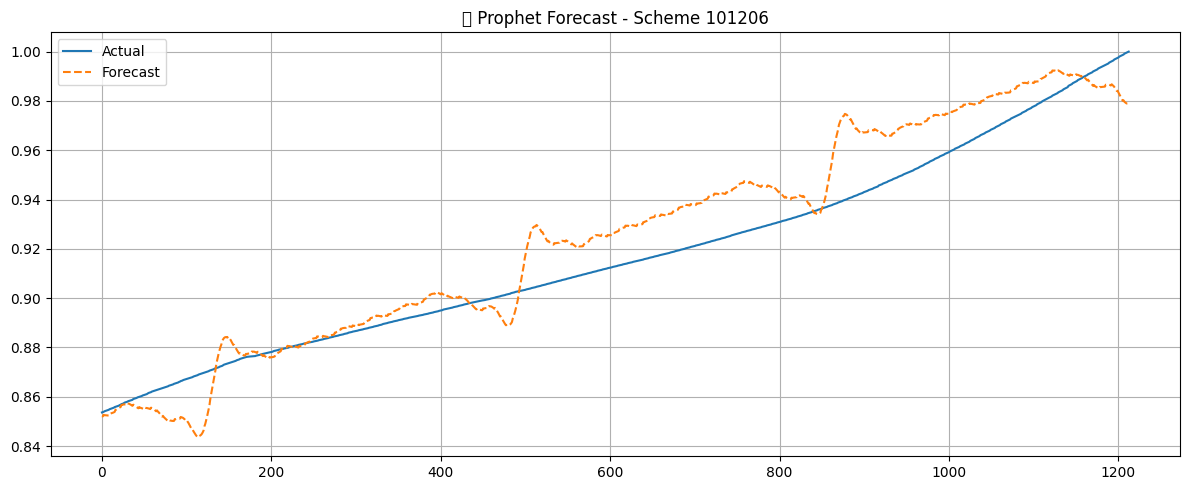


 Running Prophet for Scheme: 103140


22:12:39 - cmdstanpy - INFO - Chain [1] start processing
22:12:43 - cmdstanpy - INFO - Chain [1] done processing



 Running Prophet for Scheme: 102012


22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing



 Running Prophet for Scheme: 102008


22:12:50 - cmdstanpy - INFO - Chain [1] start processing
22:12:51 - cmdstanpy - INFO - Chain [1] done processing



 Running Prophet for Scheme: 102009


22:12:53 - cmdstanpy - INFO - Chain [1] start processing
22:12:55 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
results_prophet = []
prophet_forecasts = {}

for code in top_5_schemes:
    print(f"\n Running Prophet for Scheme: {code}")
    scheme_df = df[df['Scheme_Code'] == code].sort_values('Date')

    try:
        y_true, y_pred, rmse, mae, model, full_forecast = run_prophet_forecast(scheme_df)

        # Save results
        prophet_forecasts[code] = {
            'y_test': y_true,
            'y_pred': y_pred,
            'rmse': rmse,
            'mae': mae
        }

        results_prophet.append({
            'Scheme_Code': code,
            'RMSE': rmse,
            'MAE': mae
        })

        # Plot only first scheme
        if code == top_5_schemes[0]:
            plt.figure(figsize=(12, 5))
            plt.plot(y_true, label='Actual')
            plt.plot(y_pred, label='Forecast', linestyle='--')
            plt.title(f'📈 Prophet Forecast - Scheme {code}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f" Error with Prophet for {code}: {e}")


In [54]:
results_prophet_df = pd.DataFrame(results_prophet).sort_values(by='RMSE')
print("\n Prophet Leaderboard:")
display(results_prophet_df)



 Prophet Leaderboard:


,Scheme_Code,RMSE,MAE
2,102012,0.010391,0.009276
4,102009,0.013123,0.011564
0,101206,0.013278,0.010946
1,103140,0.060047,0.046679
3,102008,0.417018,0.340680


## Compare ARIMA vs LSTM vs Prophet in a single table

In [55]:
# Rename Columns for Clarity
results_arima = results_df.rename(columns={'RMSE': 'ARIMA_RMSE', 'MAE': 'ARIMA_MAE'})
results_lstm = results_lstm_df.rename(columns={'RMSE': 'LSTM_RMSE', 'MAE': 'LSTM_MAE'})
results_prophet = results_prophet_df.rename(columns={'RMSE': 'Prophet_RMSE', 'MAE': 'Prophet_MAE'})


In [56]:
# Merge All Three Tables on Scheme_Code

comparison_df = results_arima[['Scheme_Code', 'ARIMA_RMSE', 'ARIMA_MAE']] \
    .merge(results_lstm[['Scheme_Code', 'LSTM_RMSE', 'LSTM_MAE']], on='Scheme_Code') \
    .merge(results_prophet[['Scheme_Code', 'Prophet_RMSE', 'Prophet_MAE']], on='Scheme_Code')

In [57]:
# Sort by RMSE

comparison_df = comparison_df.sort_values(by='ARIMA_RMSE')

In [58]:
# Display Final Comparison Table

print(" Model Comparison Across Top 5 Schemes:")
display(comparison_df)

 Model Comparison Across Top 5 Schemes:


,Scheme_Code,ARIMA_RMSE,ARIMA_MAE,LSTM_RMSE,LSTM_MAE,Prophet_RMSE,Prophet_MAE
0,103140,0.055611,0.042457,0.010989,0.007837,0.060047,0.046679
1,101206,0.074520,0.064020,0.017000,0.015993,0.013278,0.010946
2,102009,0.124912,0.110629,0.030250,0.025921,0.013123,0.011564
3,102008,0.466392,0.391786,0.011130,0.007961,0.417018,0.340680


In [59]:
# Who Wins Per Scheme?

comparison_df['Best_Model'] = comparison_df[['ARIMA_RMSE', 'LSTM_RMSE', 'Prophet_RMSE']].idxmin(axis=1)
comparison_df['Best_Model']

0       LSTM_RMSE
1    Prophet_RMSE
2    Prophet_RMSE
3       LSTM_RMSE
Name: Best_Model, dtype: object

# Cluster Mutual Funds Using K-Means

In [60]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [61]:
# Prepare Features for Clustering
# Group by Scheme_Code and compute meaningful stats

# Aggregated fund-level features
features_df = df.groupby('Scheme_Code').agg({
    'NAV': ['mean', 'std', 'min', 'max'],
    'NAV_scaled': ['mean', 'std']
})

# Flatten MultiIndex columns
features_df.columns = ['_'.join(col) for col in features_df.columns]
features_df.dropna(inplace=True)

print(" Aggregated feature shape:", features_df.shape)
features_df.head()


 Aggregated feature shape: (34177, 6)


,NAV_mean,NAV_std,NAV_min,NAV_max,NAV_scaled_mean,NAV_scaled_std
Scheme_Code,,,,,,
100027,10.449669,0.271592,10.0774,11.0823,0.370454,0.270267
100028,10.359527,0.200754,10.0133,10.7316,0.482009,0.279485
100029,17.276039,0.896673,16.0552,18.9816,0.417181,0.306408
100030,10.561932,0.325936,10.0899,11.3240,0.382491,0.264108
100031,10.068503,0.045612,9.9900,10.2823,0.268571,0.156045


In [62]:
# Scale Features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

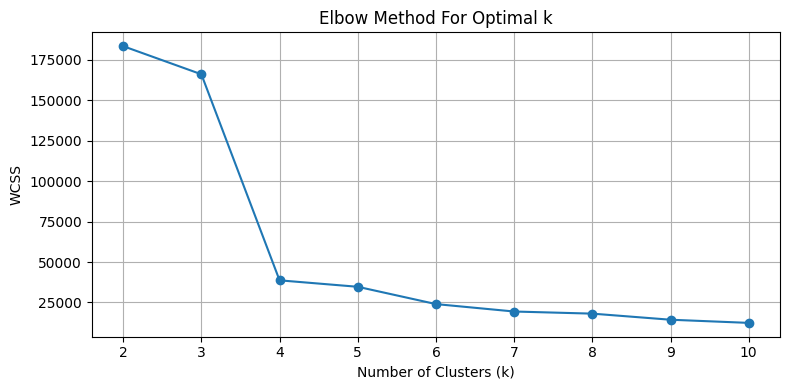

In [63]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K_range = range(2, 11)  # Try k from 2 to 10

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    wcss.append(model.inertia_)  # inertia_ is total within-cluster sum of squares

# Plot the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
# Apply K-Means Clustering

k = 4  # you can tune this later
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

features_df['Cluster'] = clusters

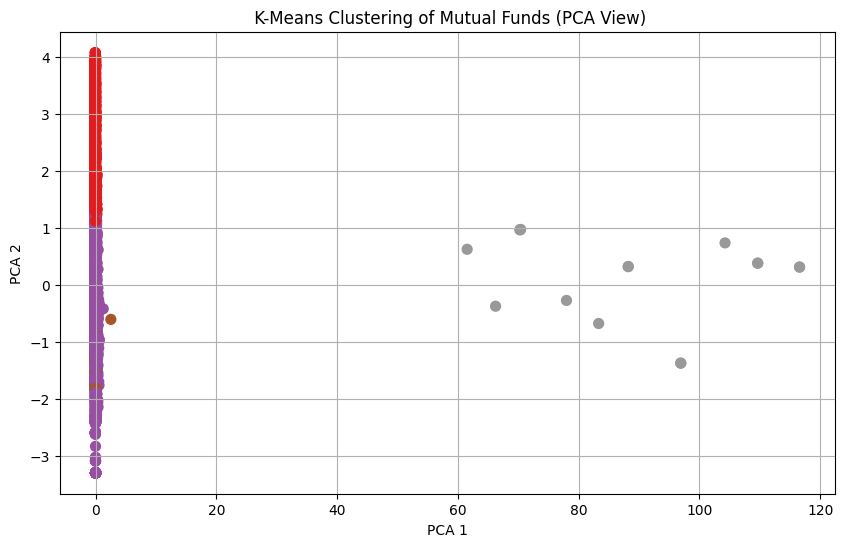

In [65]:
# Visualize Clusters using PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters, cmap='Set1', s=50)
plt.title(' K-Means Clustering of Mutual Funds (PCA View)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()